In [1]:
'''
=====Experiment=====
Dataset: BoT-IoT dataset

Training with whole graph
Split train and test randomly

Combined IP and Port features
'''

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Datasets.BoT_IoT.BoT_IoT_config import BoT_IoT_Config

In [2]:
csv_file_name = "all_raw"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"BoT_IoT/All/{csv_file_name}.csv"))

DATASET_NAME = "BoT_IoT"
EXPERIMENT_NAME = "whole_graph_combined_ports"

SOURCE_IP_COL_NAME = BoT_IoT_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = BoT_IoT_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = BoT_IoT_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = BoT_IoT_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = BoT_IoT_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = BoT_IoT_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = BoT_IoT_Config.BENIGN_CLASS_NAME

TIME_COLS = BoT_IoT_Config.TIME_COL_NAMES

print(data[ATTACK_CLASS_COL_NAME].value_counts())
print(data[IS_ATTACK_COL_NAME].value_counts())

MULTICLASS = True

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
    data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
else:
    label_col = IS_ATTACK_COL_NAME
    data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)

saves_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, EXPERIMENT_NAME)

checkpoint_path = os.path.join(saves_path, f"checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(saves_path, f"best_model_{csv_file_name}.pth")

os.makedirs(saves_path, exist_ok=True)

/tmp/ipykernel_1765903/469925867.py:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(project_root, "Datasets", f"BoT_IoT/All/{csv_file_name}.csv"))


category
DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: count, dtype: int64
attack
1    3668045
0        477
Name: count, dtype: int64


In [3]:
data.drop(columns=BoT_IoT_Config.DROP_COLS,inplace=True)
data.drop(columns=BoT_IoT_Config.TIME_COL_NAMES)
print(data.columns)

Index(['pkSeqID', 'stime', 'flgs_number', 'proto_number', 'saddr', 'sport',
       'daddr', 'dport', 'pkts', 'bytes', 'state_number', 'ltime', 'dur',
       'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category'],
      dtype='object')


In [ ]:
data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

# # Combine Port and IP
data[SOURCE_PORT_COL_NAME] = data[SOURCE_PORT_COL_NAME].apply(str)
data[DESTINATION_PORT_COL_NAME] = data[DESTINATION_PORT_COL_NAME].apply(str)

data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME] + ':' + data[SOURCE_PORT_COL_NAME]
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME] + ':' + data[DESTINATION_PORT_COL_NAME]
data.drop(columns=[SOURCE_PORT_COL_NAME,DESTINATION_PORT_COL_NAME],inplace=True)

data = pd.get_dummies(data, columns = BoT_IoT_Config.CATEGORICAL_COLS) # One Hot Encoding for categorical data
converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(BoT_IoT_Config.CATEGORICAL_COLS))]

In [5]:
print(data.head)

<bound method NDFrame.head of          pkSeqID         stime                  saddr                 daddr  \
0        3576925  1.526344e+09       192.168.100.3:80   192.168.100.55:8080   
1        3576926  1.526344e+09    192.168.100.46:3456      192.168.100.5:80   
2        3576919  1.526344e+09      192.168.100.46:80      192.168.100.5:80   
3        3576920  1.526344e+09      192.168.100.46:80      192.168.100.5:80   
4        3576922  1.526344e+09      192.168.100.7:365     192.168.100.3:565   
...          ...           ...                    ...                   ...   
3668517  3668517  1.529381e+09  192.168.100.150:35062      192.168.100.3:22   
3668518  3668518  1.529381e+09  192.168.100.150:35064      192.168.100.3:22   
3668519  3668519  1.529381e+09  192.168.100.150:35066      192.168.100.3:22   
3668520  3668520  1.529381e+09  192.168.100.150:35070      192.168.100.3:22   
3668521  3668521  1.529381e+09    192.168.100.3:43001  192.168.100.150:4433   

          pkts     by

In [6]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)
data.drop(columns=['index'],inplace=True)
print(data.head)

<bound method NDFrame.head of          pkSeqID         stime                  saddr                 daddr  \
0        3576925  1.526344e+09       192.168.100.3:80   192.168.100.55:8080   
1        3576926  1.526344e+09    192.168.100.46:3456      192.168.100.5:80   
2        3576919  1.526344e+09      192.168.100.46:80      192.168.100.5:80   
3        3576920  1.526344e+09      192.168.100.46:80      192.168.100.5:80   
4        3576922  1.526344e+09      192.168.100.7:365     192.168.100.3:565   
...          ...           ...                    ...                   ...   
3668517  3668517  1.529381e+09  192.168.100.150:35062      192.168.100.3:22   
3668518  3668518  1.529381e+09  192.168.100.150:35064      192.168.100.3:22   
3668519  3668519  1.529381e+09  192.168.100.150:35066      192.168.100.3:22   
3668520  3668520  1.529381e+09  192.168.100.150:35070      192.168.100.3:22   
3668521  3668521  1.529381e+09    192.168.100.3:43001  192.168.100.150:4433   

          pkts     by

In [7]:
scaler = StandardScaler()
cols_to_norm = BoT_IoT_Config.COLS_TO_NORM
print(data[cols_to_norm].describe()) # Check if there's any too large value

               pkts         bytes           dur          mean        stddev  \
count  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean   7.725963e+00  8.690501e+02  2.033479e+01  2.231063e+00  8.871499e-01   
std    1.155876e+02  1.122667e+05  2.148764e+01  1.517728e+00  8.037139e-01   
min    1.000000e+00  6.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.000000e+00  4.200000e+02  1.256256e+01  1.819670e-01  3.001900e-02   
50%    7.000000e+00  6.000000e+02  1.550852e+01  2.690125e+00  7.938960e-01   
75%    9.000000e+00  7.700000e+02  2.709986e+01  3.565203e+00  1.745296e+00   
max    7.005700e+04  7.183334e+07  2.771485e+03  4.981882e+00  2.496763e+00   

                sum           min           max         spkts         dpkts  \
count  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean   7.721635e+00  1.017540e+00  3.020015e+00  7.314146e+00  4.118173e-01   
std    7.616199e+00  1.483688e+00  1.860877e+00  7.

In [8]:
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Try to clip the column
            df[col] = df[col].clip(lower=-1e9, upper=1e9)
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, BoT_IoT_Config.COLS_TO_NORM)


✅ All other columns processed successfully.


In [9]:
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [10]:
from sklearn.preprocessing import LabelEncoder

num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)


['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
Attack label mapping: {'DDoS': 0, 'DoS': 1, 'Normal': 2, 'Reconnaissance': 3, 'Theft': 4}


In [11]:
# 70% train, 15% validation, 15% test
train_full_df, test_df = train_test_split(
     data, test_size=0.15, random_state=42, stratify=data[label_col])


feature_cols = cols_to_norm + converted_categorical_cols

print('Feature Columns:', feature_cols)

train_full_df['h'] = train_full_df[ feature_cols ].values.tolist()
test_df['h'] = test_df[ feature_cols ].values.tolist()

y_train = train_full_df[label_col]
y_test = test_df[label_col]

pd.set_option('display.max_columns', None)

print("Number of training samples:", len(train_full_df))
print(y_train.value_counts())
print("Number of test samples:", len(test_df))
print(y_test.value_counts())

print(train_full_df.head(5))

Feature Columns: ['pkts', 'bytes', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'flgs_number_1', 'flgs_number_2', 'flgs_number_3', 'flgs_number_4', 'flgs_number_5', 'flgs_number_6', 'flgs_number_7', 'flgs_number_8', 'flgs_number_9', 'state_number_1', 'state_number_2', 'state_number_3', 'state_number_4', 'state_number_5', 'state_number_6', 'state_number_7', 'state_number_8', 'state_number_9', 'state_number_10', 'state_number_11', 'proto_number_1', 'proto_number_2', 'proto_number_3', 'proto_number_4', 'proto_number_5']
Number of training samples: 3118243
category
0    1637630
1    1402721
3      77420
2        405
4         67
Name: count, d

In [12]:
def create_graph(df, source_ip_col, destination_ip_col, edge_attr, create_using=nx.MultiDiGraph(), **kwargs):
    G_nx = nx.from_pandas_edgelist(df, source_ip_col, destination_ip_col, edge_attr, create_using=create_using, **kwargs)
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    print("Number of edges in G_pyg:", num_edges)
    print("Number of node in G_pyg:", num_nodes)
    print("Shape of node in G_pyg:", G_pyg.x.shape)
    print("Shape of edge attr in G_pyg:", G_pyg.edge_attr.shape)
    print("Shape of edge label in G_pyg:", G_pyg.edge_label.shape)

    return G_nx, G_pyg

In [13]:
G_nx_test, G_pyg_test = create_graph(test_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

Number of edges in G_pyg: 550279
Number of node in G_pyg: 55944
Shape of node in G_pyg: torch.Size([55944, 54])
Shape of edge attr in G_pyg: torch.Size([550279, 54])
Shape of edge label in G_pyg: torch.Size([550279])


In [14]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [15]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
th.cuda.empty_cache()

In [17]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(data, epochs, learning_rates, hidden_dims, drop_outs):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    best_params = {}
    best_f1 = 0

    # Precompute the train and validation graphs for all folds
    folds = []
    for train_idx, val_idx in skf.split(data, data[label_col]):
        train_df = data.iloc[train_idx]
        val_df = data.iloc[val_idx]

        G_nx_train, G_pyg_train = create_graph(train_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
        G_nx_val, G_pyg_val = create_graph(val_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

        G_pyg_train = G_pyg_train.to(device)
        G_pyg_val = G_pyg_val.to(device)

        G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
        G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

        G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
        G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

        folds.append((G_pyg_train, G_pyg_val))

    params_results = {}
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}, drop_out: {drop_out}")
                fold_f1_scores = []

                for fold, (G_pyg_train, G_pyg_val) in enumerate(folds):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=G_pyg_train.num_node_features,
                                    edge_in_channels=G_pyg_train.num_edge_features,
                                    hidden_channels=hidden_dim,
                                    dropout=drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    labels = G_pyg_train.edge_label.cpu().numpy()
                    class_weights = class_weight.compute_class_weight('balanced',
                                                                    classes=np.unique(labels),
                                                                    y=labels)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)
                    scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

                    best_epoch_f1 = 0  # Track the best F1 score for this fold

                    for epoch in range(epochs):
                        train_loss = 0
                        val_loss = 0

                        try:
                            model.train()
                            out = model(G_pyg_train)
                            
                            optimizer.zero_grad()
                            loss = criterion(out, G_pyg_train.edge_label)
                            train_loss = loss.item()

                            loss.backward()
                            optimizer.step()
                            scheduler.step()

                            model.eval()
                            with th.no_grad():
                                out = model(G_pyg_val)
                                loss = criterion(out, G_pyg_val.edge_label)
                                val_loss = loss.item()

                            val_f1 = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='weighted')

                            if val_f1 > best_epoch_f1:
                                best_epoch_f1 = val_f1  # Update the best F1 score for this fold
                                print(f"Best F1 Score at epoch {epoch}: {best_epoch_f1:.4f}, Parameters: lr={lr}, hidden_dim={hidden_dim}, drop_out={drop_out}")

                            if epoch % 100 == 0:
                                print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print("Current Results: ", params_results)
                print(f"Average F1 Score for dropout {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

        print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
        print("All results:", params_results)


learning_rates = [0.001, 0.005, 0.01]
hidden_dims = [128, 256, 512]
drop_outs = [0.2, 0.3, 0.4]

grid_search(train_full_df, epochs=200, learning_rates=learning_rates, hidden_dims=hidden_dims, drop_outs=drop_outs)


KeyboardInterrupt: 

: 

In [ ]:
train_df, val_df = train_test_split(
     train_full_df, test_size=0.15, random_state=42, stratify=train_full_df[label_col])

G_nx_train, G_pyg_train = create_graph(train_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
G_nx_val, G_pyg_val = create_graph(val_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())


Number of edges in G_pyg: 2650506
Number of node in G_pyg: 181948
Shape of node in G_pyg: torch.Size([181948, 54])
Shape of edge attr in G_pyg: torch.Size([2650506, 54])
Shape of edge label in G_pyg: torch.Size([2650506])
Number of edges in G_pyg: 467737
Number of node in G_pyg: 48818
Shape of node in G_pyg: torch.Size([48818, 54])
Shape of edge attr in G_pyg: torch.Size([467737, 54])
Shape of edge label in G_pyg: torch.Size([467737])


In [ ]:
import pickle

def save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs):
    global checkpoint_path, train_loss_history_path, val_loss_history_path, val_f1_history_path, saved_model_epochs_path

    # Save checkpoint
    th.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_f1': best_f1
    }, checkpoint_path)
    with open(train_loss_history_path, 'wb') as f:
        pickle.dump(train_loss_history, f)
    with open(val_loss_history_path, 'wb') as f:
        pickle.dump(val_loss_history, f)
    with open(val_f1_history_path, 'wb') as f:
        pickle.dump(val_f1_history, f)
    with open(saved_model_epochs_path, 'wb') as f:
        pickle.dump(saved_model_epochs, f)

In [ ]:
# Extract the best parameters from the grid search
best_hidden_dim = 128  # Replace with the best hidden_dim found
best_learning_rate = 0.001  # Replace with the best learning_rate found
best_dropout = 0.2  # Replace with the best dropout found
epochs = 1000

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=G_pyg_train.num_node_features,
                   edge_in_channels=G_pyg_train.num_edge_features,
                   hidden_channels=best_hidden_dim,
                   dropout=best_dropout,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Compute class weights for the training dataset
labels = G_pyg_train.edge_label.cpu().numpy()
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)

# Normalize class weights
class_weights = th.FloatTensor(class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
scheduler = th.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

# Move the graph data to the device
G_pyg_train = G_pyg_train.to(device)
G_pyg_val = G_pyg_val.to(device)

G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

# ===== Load checkpoint if exists =====
best_f1 = 0
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"Resumed training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

train_loss_history_path = os.path.join(saves_path, 'train_loss_history.pkl')
val_loss_history_path = os.path.join(saves_path, 'val_loss_history.pkl')
val_f1_history_path = os.path.join(saves_path, 'val_f1_history.pkl')
saved_model_epochs_path = os.path.join(saves_path, 'saved_model_epochs.pkl')

if os.path.exists(train_loss_history_path) and os.path.exists(val_loss_history_path) and os.path.exists(val_f1_history_path) and os.path.exists(saved_model_epochs_path):
    with open(train_loss_history_path, 'rb') as f:
        train_loss_history = pickle.load(f)
    with open(val_loss_history_path, 'rb') as f:
        val_loss_history = pickle.load(f)
    with open(val_f1_history_path, 'rb') as f:
        val_f1_history = pickle.load(f)
    with open(saved_model_epochs_path, 'rb') as f:
        saved_model_epochs = pickle.load(f)

# ===== Start Training =====
for epoch in range(start_epoch, epochs):
    train_loss = 0
    val_loss = 0

    model.train()
    out = model(G_pyg_train)

    optimizer.zero_grad()
    loss = criterion(out, G_pyg_train.edge_label)
    train_loss = loss.item()

    loss.backward()
    optimizer.step()
    scheduler.step()

    model.eval()
    with th.no_grad():
        out = model(G_pyg_val)
        loss = criterion(out, G_pyg_val.edge_label)
        val_loss = loss.item()

    val_f1 = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='weighted')
    val_f1_micro = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='micro')
    val_f1_macro = f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='macro')

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

    if val_f1 > best_f1:
        best_f1 = val_f1  # Update the best F1 score for this fold
        best_model_state = model.state_dict()
        saved_model_epochs.append(epoch)

        save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)
        th.save(best_model_state, best_model_path)
        print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

    if epoch % 10 == 0:
        # Save checkpoint
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')
        save_progress(epoch, model, optimizer, best_f1, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

# Save the trained model
print("Model training completed and saved.")

Class weights: tensor([3.8082e-01, 4.4460e-01, 1.5410e+03, 8.0554e+00, 9.3000e+03],
       device='cuda:0')
Resumed training from epoch 751


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.53 GiB. GPU 0 has a total capacity of 23.49 GiB of which 360.69 MiB is free. Process 1754569 has 13.03 GiB memory in use. Including non-PyTorch memory, this process has 10.09 GiB memory in use. Of the allocated memory 7.38 GiB is allocated by PyTorch, and 2.45 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_losses, label='Train Loss', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_losses))

    plt.tight_layout()
    plt.show()

752


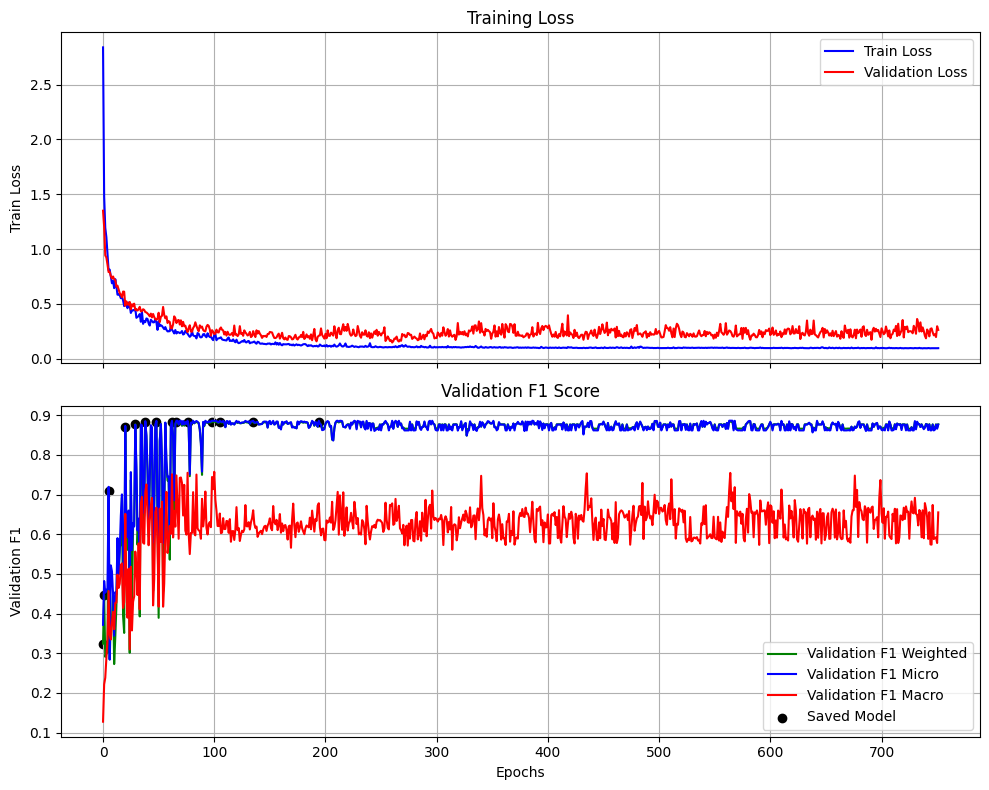

In [ ]:
plot_training_process(train_loss_history, val_loss_history, val_f1_history, saved_model_epochs)

In [ ]:
G_nx_test, G_pyg_test = create_graph(test_df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())

Number of edges in G_pyg: 550279
Number of node in G_pyg: 55944
Shape of node in G_pyg: torch.Size([55944, 54])
Shape of edge attr in G_pyg: torch.Size([550279, 54])
Shape of edge label in G_pyg: torch.Size([550279])


In [ ]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(G_pyg_test, adversarial=False):

    G_pyg_test = G_pyg_test.to(device)
    G_pyg_test.edge_label = G_pyg_test.edge_label.to(device)
    G_pyg_test.edge_attr = G_pyg_test.edge_attr.to(device)

    best_model = EGraphSAGE(node_in_channels=G_pyg_test.num_node_features, 
                       edge_in_channels=G_pyg_test.num_edge_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path))
    best_model = best_model.to(device)

    best_model.eval()

    print("inference start")
    with th.no_grad():
            
        try:
            out = best_model(G_pyg_test)
            
        except Exception as forward_error:
            print(f"Error during forward/backward pass at {forward_error}")

    print("inference done")

    pred_labels = out.argmax(dim=1).cpu()
    all_test_labels = G_pyg_test.edge_label.cpu()

    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]
        
        

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)


    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4)
    print(report)

    
eval(G_pyg_test)


Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/whole_graph_combined_ports/best_model_all_raw.pth
inference start
inference done
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[224555  64292     46      3     98]
 [  5972 241312    253      1      1]
 [     1      3     68      0      0]
 [   104      7     27  13499     25]
 [     0      0      3      3      6]]
                precision    recall  f1-score   support

          DDoS     0.9737    0.7770    0.8643    288994
           DoS     0.7896    0.9748    0.8725    247539
        Normal     0.1713    0.9444    0.2900        72
Reconnaissance     0.9995    0.9881    0.9937     13662
         Theft     0.0462    0.5000    0.0845        12

      accuracy                         0.8713    550279
     macro avg     0.5960    0.8369    0.6210    550279
  weighted avg     0.8914    0.8713    0.8711    550279



In [ ]:
def inject_traffic_to_attacker(graph, ratio=0.1, num_injected_nodes=1, is_attack=False):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # 1. Identify attacker nodes
    attacker_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
    attacker_nodes = th.unique(edge_index[:, attacker_edges])
    if attacker_nodes.numel() == 0:
        raise ValueError("No attacker nodes found.")

    # 2. Sample benign edge feature pool
    if is_attack:
        attack_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[attack_edges]
    else:
        benign_edges = (edge_label == BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[benign_edges]

    # 3. Inject new nodes
    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    
    for _ in range(num_to_inject):
        src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes

        dst = attacker_nodes[random.randint(0, len(attacker_nodes) - 1)].item()

        new_edges.append([src, dst])
        attr = inject_edge_attr_pool[random.randint(0, len(inject_edge_attr_pool) - 1)]
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

        # new_graph.first_injected_node_idx = original_num_nodes # Store injected node indices

    return new_graph


In [ ]:
# Inject Attack Traffic to Attacker Nodes
G_pyg_test = G_pyg_test.cpu()
injected_graph = inject_traffic_to_attacker(G_pyg_test, 0.1, num_injected_nodes=1, is_attack=True)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/whole_graph_combined_ports/best_model_all_raw.pth
inference start
inference done
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [ 7485 18687  3833 24963    59     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[217725  64292   6976      1      0]
 [  7133 227882  12521      2      1]
 [     7      0     65      0      0]
 [    91    179   1959  11392     41]
 [     0      0      3      3      6]]
                precision    recall  f1-score   support

          DDoS     0.9679    0.7534    0.8473    288994
           DoS     0.7795    0.9206    0.8442    247539
        Normal     0.0030    0.9028    0.0060        72
Reconnaissance     0.9995    0.8338    0.9092     13662
         Theft     0.125

In [ ]:
# Inject BENIGN Traffic to Attacker Nodes
injected_graph = inject_traffic_to_attacker(G_pyg_test, 0.1, num_injected_nodes=1, is_attack=False)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/whole_graph_combined_ports/best_model_all_raw.pth
inference start
inference done
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [   34     8 53080  1118   787     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[273007    187  15751     48      1]
 [ 62255 164671  20532     80      1]
 [     2      0     70      0      0]
 [   941      0   8508   4089    124]
 [     1      0      9      2      0]]
                precision    recall  f1-score   support

          DDoS     0.8120    0.9447    0.8733    288994
           DoS     0.9989    0.6652    0.7986    247539
        Normal     0.0016    0.9722    0.0031        72
Reconnaissance     0.9692    0.2993    0.4574     13662
         Theft     0.000

In [ ]:
def inject_random_nodes(graph, ratio=0.1, num_injected_nodes=1):
	edge_index = graph.edge_index.clone()
	edge_attr = graph.edge_attr.clone()
	edge_label = graph.edge_label.clone()
	x = graph.x.clone()

	num_edges = edge_index.size(1)
	feature_dim = graph.x.size(1)

	# 1. Inject new nodes
	original_num_nodes = x.size(0)
	new_node_feats = th.ones((num_injected_nodes, feature_dim))
	x = th.cat([x, new_node_feats], dim=0)

	# 2. Inject random edges
	num_to_inject = max(1, int(ratio * num_edges))
	new_edges = []
	new_attrs = []
	new_labels = []

	for _ in range(num_to_inject):
		src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
		dst = random.randint(0, original_num_nodes - 1)  # to existing nodes

		new_edges.append([src, dst])
		attr = edge_attr[random.randint(0, len(edge_attr) - 1)]  # Randomly sample edge attributes
		new_attrs.append(attr)
		new_labels.append(ADVERSARIAL_CLASS_LABEL)  # Assign benign class label to new edges

	# 3. Merge into graph
	if new_edges:
		new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
		new_attrs = th.stack(new_attrs)
		new_labels = th.tensor(new_labels, dtype=th.long)

		edge_index = th.cat([edge_index, new_edges], dim=1)
		edge_attr = th.cat([edge_attr, new_attrs], dim=0)
		edge_label = th.cat([edge_label, new_labels], dim=0)

	# Create a new graph with the injected nodes and edges
	new_graph = Data(
		edge_index=edge_index,
		edge_attr=edge_attr,
		edge_label=edge_label,
		x=x
	)

	return new_graph

In [ ]:
# Inject Random Nodes in the graph
injected_graph = inject_random_nodes(G_pyg_test, 0.1, num_injected_nodes=1)
eval(injected_graph, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/BoT_IoT/whole_graph_combined_ports/best_model_all_raw.pth
inference start
inference done
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [ 6877 23163  3513 21405    69     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[281385    187   7324      0     98]
 [ 62272 171490  13771      5      1]
 [     2      1     69      0      0]
 [    90    206   2164  11144     58]
 [     0      0      3      3      6]]
                precision    recall  f1-score   support

          DDoS     0.8186    0.9737    0.8894    288994
           DoS     0.9977    0.6928    0.8177    247539
        Normal     0.0030    0.9583    0.0059        72
Reconnaissance     0.9993    0.8157    0.8982     13662
         Theft     0.036